# This is the Saildrone and HF Radar collocation code. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

In [3]:
filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-10_minutes-v1_withloggers_matchedadcp_v3.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-10_minutes-v1_withloggers_matchedadcp_v4.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
#ds_usv = ds_usv.swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-11T18:30',ds_usv.time[-1].data))  #first part of data is when USV being towed, elminiate
#ds_usv['vel_east_30m_ave']=ds_usv.vel_east.sel()
ds_usv = ds_usv.swap_dims({'cell':'cell_depth'})
#ds_usv_tem = ds_usv.sel(cell_depth=slice(0,30)).mean('cell_depth')  #make a mean of the top 30 m
ds_usv2 = ds_usv.copy(deep=True)
ds_usv = ds_usv.isel(cell_depth=0)
#ds_usv['vel_east_30m']=ds_usv_tem.vel_east
#ds_usv['vel_north_30m']=ds_usv_tem.vel_north
#ds_usv['spd_30m']=np.sqrt(ds_usv.vel_east_30m**2+ds_usv.vel_north_30m**2)
ds_usv_subset = ds_usv.copy(deep=True)
ds_usv_subset2 = ds_usv2.copy(deep=True)
ds_usv_subset['spd']=np.sqrt(ds_usv_subset.vel_east**2+ds_usv_subset.vel_north**2)
ds_usv_subset['spd2']=np.sqrt((ds_usv_subset.vel_east*.5144)**2+(ds_usv_subset.vel_north*.5144)**2)
ds_usv_subset['dir']=np.arctan2(ds_usv_subset.vel_north,ds_usv_subset.vel_east)*180/np.pi
ds_usv_subset['ship_spd']=np.sqrt(ds_usv_subset.ship_vel_east**2+ds_usv_subset.ship_vel_north**2)
ds_usv_subset['ship_dir']=np.arctan2(ds_usv_subset.ship_vel_north,ds_usv_subset.ship_vel_east)*180/np.pi
ds_usv_subset

<xarray.Dataset>
Dimensions:                               (beam: 4, time: 8760)
Coordinates:
    trajectory                            float32 1002.0
  * time                                  (time) datetime64[ns] 2018-04-11T19:50:00 ... 2018-06-11T20:10:00
    cell_depth                            float32 4.2
Dimensions without coordinates: beam
Data variables:
    SOG                                   (time) float64 1.908 1.81 ... nan nan
    COG                                   (time) float64 198.9 268.6 ... nan nan
    HDG                                   (time) float64 191.0 288.8 ... nan nan
    HDG_WING                              (time) float64 215.7 258.9 ... nan nan
    ROLL                                  (time) float64 7.5 10.32 ... nan nan
    PITCH                                 (time) float64 1.52 2.24 ... nan nan
    WING_ANGLE                            (time) float64 24.94 -30.3 ... nan nan
    BARO_PRES_MEAN                        (time) float64 1.018e+03 ... n

# Read in HFradar data
Read in data using open_mfdataset with the option coords='minimal'



In [4]:
#hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd'
hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd'
ds_sat = xr.open_dataset(hf_filename)
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data),
                   time=slice(ds_usv_subset.time.min().data,ds_usv_subset.time.max().data))
subset.load()  #this loads data into memory instead of leaving it lazy.  the hf radar opendap need this for some reason
subset['spd']=np.sqrt(subset.u**2+subset.v**2)
subset['dir']=np.arctan2(subset.v,subset.u)*180/np.pi

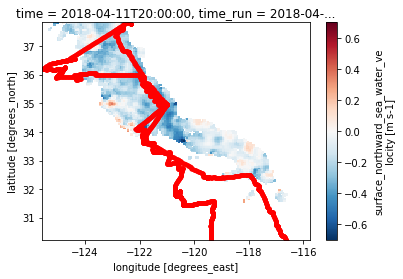

In [5]:
subset.v[0,:,:].plot()
plt.plot(ds_usv_subset.lon,ds_usv_subset.lat,'r.-')

In [6]:
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

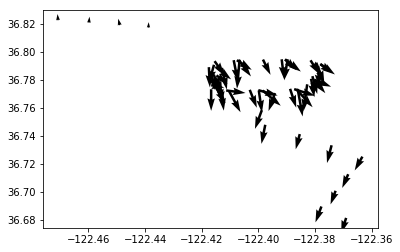

In [78]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-12T19','2018-04-13T08'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-12T19','2018-04-13T08'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_412both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


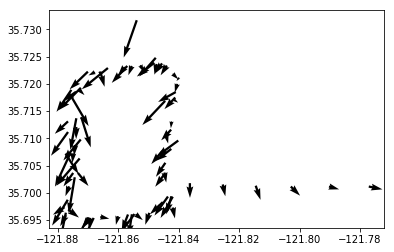

In [79]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-14T02','2018-04-14T14'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-14T02','2018-04-14T14'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_414both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


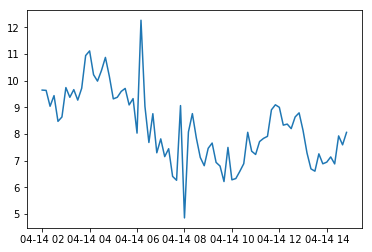

In [80]:
usv1['wspd']=np.sqrt(usv1.UWND_MEAN**2+usv1.VWND_MEAN**2)
#plt.plot(usv1.wspd,usv1.spd-hf1.spd,'.')
plt.plot(usv1.time,usv1.wspd)

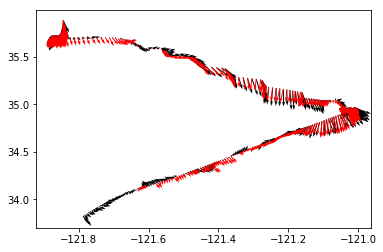

In [81]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-14','2018-04-16'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-14','2018-04-16'))
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


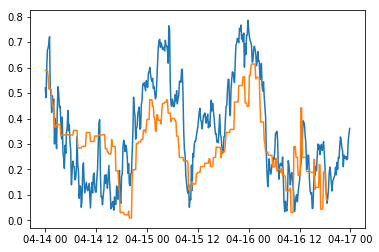

In [82]:
plt.plot(usv1.time,usv1.spd)
plt.plot(hf1.time,hf1.spd)
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries2_both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')

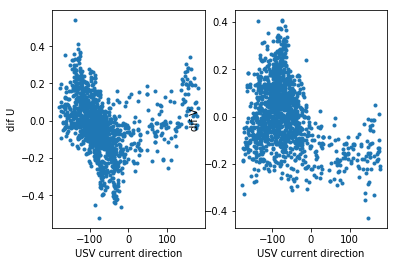

In [83]:
usv1 = ds_usv_subset.where(np.isfinite(ds_collocated.spd))
hf1 = ds_collocated_nearest.where(np.isfinite(ds_collocated.spd))
ax1=plt.subplot(1,2, 1)
ax1.plot(usv1.dir,hf1.u-usv1.vel_east,'.')
ax1.set_xlabel('USV current direction')
ax1.set_ylabel('dif U')
ax2=plt.subplot(1,2, 2)
ax2.plot(usv1.dir,hf1.v-usv1.vel_north,'.')
ax2.set_xlabel('USV current direction')
ax2.set_ylabel('dif V')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_both_wdir.png'
plt.savefig(fig_fname, transparent=False, format='png')

mean 0.05026234680304413
std 0.15365239101244357
mean 0.03216915862753498
std 0.12825959509881765
2018-04-14T02:10:00.000000000


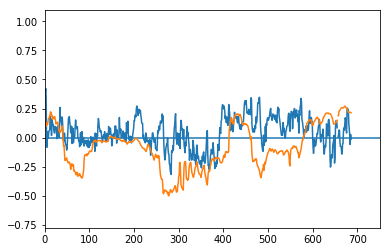

In [122]:
#2nd half of dataset seems much better
usv1 = ds_usv_subset.where(np.isfinite(ds_collocated_nearest.spd))
hf1 = ds_collocated_nearest.where(np.isfinite(ds_collocated_nearest.spd))
plt.axhline(0)
plt.plot(usv1.spd-hf1.spd)
plt.plot((usv1.TEMP_CTD_MEAN-usv1.TEMP_CTD_MEAN.mean())/(4*usv1.TEMP_CTD_MEAN.std()))
#plt.plot(usv1.dir))
plt.xlim(0,750)
#plt.xlim(6900,7550)
print('mean',(usv1.spd[6000:]-hf1.spd[6000:]).mean().data)
print('std',(usv1.spd[6000:]-hf1.spd[6000:]).std().data)
print('mean',(usv1.spd[:6000]-hf1.spd[:6000]).mean().data)
print('std',(usv1.spd[:6000]-hf1.spd[:6000]).std().data)
print(usv1.time[300].data)

In [326]:
#this doesn't work right
from sklearn.linear_model import LinearRegression
y = hf1.u.data
bnan = np.isfinite(y)
y=y[bnan]
X = usv1.vel_east.data
X = X[bnan]
X = np.array([np.ones(X.shape[0]),X])
#X = np.array([X])
print(X.shape,y.shape)
reg = LinearRegression().fit(X.transpose(), y)
print(reg.coef_)
y = hf1.v.data
bnan = np.isfinite(y)
y=y[bnan]
X = usv1.vel_north.data
X = X[bnan]
X = np.array([np.ones(X.shape[0]),X])
reg = LinearRegression().fit(X.transpose(), y)
print(reg.coef_)
y = hf1.spd.data
bnan = np.isfinite(y)
y=y[bnan]
X = usv1.spd.data
X = X[bnan]
X = np.array([np.ones(X.shape[0]),X])
reg = LinearRegression().fit(X.transpose(), y)
print(reg.coef_)

(2, 1353) (1353,)
[0.         0.44513567]
[0.         0.53846145]
[0.       0.459223]


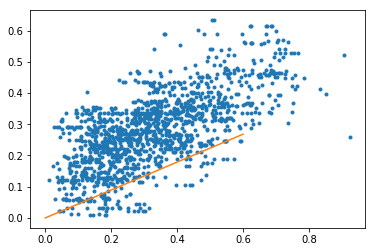

In [327]:
plt.plot(usv1.spd,hf1.spd,'.')
plt.plot([0,.6],[0,.6*.447])

# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [328]:
usv1

<xarray.Dataset>
Dimensions:                               (beam: 4, time: 8760)
Coordinates:
    lat                                   (time) float64 37.77 37.76 ... 37.78
    lon                                   (time) float64 -122.6 ... -122.3
    trajectory                            float32 1002.0
  * time                                  (time) datetime64[ns] 2018-04-11T19:50:00 ... 2018-06-11T20:10:00
    cell_depth                            float32 4.2
Dimensions without coordinates: beam
Data variables:
    SOG                                   (time) float64 nan 1.81 ... nan nan
    COG                                   (time) float64 nan 268.6 ... nan nan
    HDG                                   (time) float64 nan 288.8 ... nan nan
    HDG_WING                              (time) float64 nan 258.9 ... nan nan
    ROLL                                  (time) float64 nan 10.32 ... nan nan
    PITCH                                 (time) float64 nan 2.24 ... nan nan
    WING

In [330]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, dvu, dlat, dlon, dut = [],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.v[index]):
        continue
    if np.isnan(ds_tem.v[index]):
        continue
    print(index, ilen)
    cond = ((ds_tem.u==ds_collocated_nearest.u[index]) & (ds_tem.v==ds_collocated_nearest.v[index]))
    notcond = np.logical_not(cond)
    masked = ds_tem.where(cond)
    masked_usv = ds_usv_subset.where(cond,drop=True)
    if masked.v.sum().data==0:  #don't do if data not found
        continue
    duu=np.append(duu,masked_usv.vel_east.mean().data)
    dvu=np.append(dvu,masked_usv.vel_north.mean().data)
    dlat=np.append(dlat,masked_usv.lat.mean().data)
    dlon=np.append(dlon,masked_usv.lon.mean().data)
    tdif = masked_usv.time[-1].data-masked_usv.time[0].data
    mtime=masked_usv.time[0].data+np.timedelta64(tdif/2,'ns')
    dut=np.append(dut,mtime)
    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'u_usv': ('time',duu),
                             'v_usv': ('time',dvu),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/hf_radar_6km_downsampled_usv_data.nc')

1 8760
2 8760
5 8760
6 8760
11 8760
12 8760
17 8760
18 8760
23 8760
24 8760
25 8760
26 8760
29 8760
31 8760
35 8760
37 8760
38 8760
39 8760
40 8760
41 8760
44 8760
46 8760
47 8760
51 8760
53 8760
56 8760
59 8760
64 8760
65 8760
70 8760
71 8760
75 8760
77 8760
79 8760
83 8760
85 8760
89 8760
92 8760
93 8760
99 8760
101 8760
106 8760
107 8760
112 8760
113 8760
119 8760
121 8760
125 8760
128 8760
131 8760
135 8760
137 8760
141 8760
143 8760
144 8760
147 8760
148 8760
153 8760
154 8760
165 8760
168 8760
171 8760
174 8760
177 8760
178 8760
183 8760
184 8760
189 8760
190 8760
195 8760
200 8760
201 8760
207 8760
213 8760
219 8760
222 8760
225 8760
226 8760
231 8760
233 8760
237 8760
239 8760
241 8760
243 8760
248 8760
249 8760
254 8760
255 8760
258 8760
260 8760
261 8760
264 8760
267 8760
270 8760
273 8760
274 8760
278 8760
279 8760
282 8760
285 8760
287 8760
291 8760
292 8760
296 8760
297 8760
300 8760
303 8760
309 8760
315 8760
327 8760
333 8760
339 8760
345 8760
351 8760
357 8760
363 8760


# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [331]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:       (nProcParam: 7, nSites: 59, time: 461)
Coordinates:
    lat           (time) float64 37.76 37.75 35.55 37.7 ... 37.79 37.8 37.79
    lon           (time) float64 -122.6 -122.6 -121.4 ... -122.5 -122.5 -122.4
  * time          (time) datetime64[ns] 2018-04-11T20:00:00 ... 2018-06-10T23:45:00
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 37.08943 38.317318 ... 39.438015 38.567184
    site_lon      (nSites) float32 -122.27415 -123.072464 ... -123.33155
    site_code     (nSites) |S64 b'BIGC                     ' ... b'GCVE                     '
    site_netCode  (nSites) |S64 b'NPS                      ' ... b'BML                      '
    procParams    (nProcParam) float32 10.0 100.0 2.0 3.0 0.0 0.0 10.0
    u             (time) float64 -0.221 -0.1565 0.2197 -0.05727 ... nan nan nan
    v             (time) float64 -0.4139 -0.3995 -0.08815 ... nan nan nan
    DOPx          (time) float64 0.05271 0

In [332]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/hf_radar_6km_downsampled_collocated_usv_data.nc')


In [333]:
ds_collocated_averaged['spd']=np.sqrt(ds_collocated_averaged.u**2+ds_collocated_averaged.v**2)
ds_new['spd'] = np.sqrt(ds_new.u_usv**2+ds_new.v_usv**2)
ds_collocated_averaged['dir']=np.arctan2(ds_collocated_averaged.v,ds_collocated_averaged.u)*180./np.pi
ds_new['dir'] = np.arctan2(ds_new.v_usv,ds_new.u_usv)*180./np.pi

usv_spd = ds_new.spd
sat_spd = ds_collocated_averaged.spd
usv_dir = ds_new.dir
sat_dir = ds_collocated_averaged.dir
dif_spd,dif_dir = usv_spd - sat_spd, usv_dir - sat_dir
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
cond,cond2 = (dif_dir > 180),(dif_dir < -180)
dif_dir[cond]-=360
dif_dir[cond2]+=360
print('mean,std dif speed',[dif_spd.mean().data,dif_spd.std().data])
print('mean,std dir',[dif_dir.mean().data,dif_dir.std().data,dif_spd.shape[0]])



mean,std dif speed [array(0.05032059), array(0.12539932)]
mean,std dir [array(6.55931061), array(47.02380045), 461]


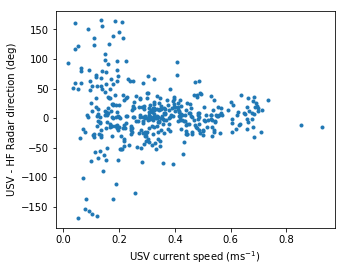

In [36]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,dif_dir,'.')
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - HF Radar direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_wdir_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


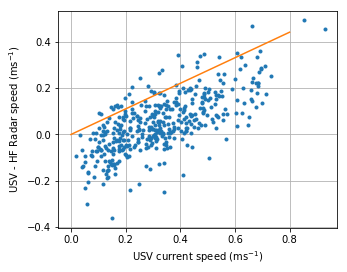

In [234]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(usv_spd,dif_spd,'.')
ax.set_xlabel('USV current speed (ms$^{-1}$)')
ax.set_ylabel('USV - HF Radar speed (ms$^{-1}$)')
ax.plot([0,.8],[0,.8-.8*0.44719377])
ax.grid()
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_wspd_wspd_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


In [312]:
#try to use 1km data just for a day
#hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd'
hf_filename = 'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd'
ds_sat = xr.open_dataset(hf_filename)
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(32,33),
                   time=slice('2018-04-20T01','2018-04-22T22'))
#subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
#                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data),
#                   time=slice('2018-04-20T01','2018-04-22T22'))
subset.load()  #this loads data into memory instead of leaving it lazy.  the hf radar opendap need this for some reason
subset['spd']=np.sqrt(subset.u**2+subset.v**2)
subset['dir']=np.arctan2(subset.v,subset.u)*180/np.pi

In [313]:
#now collocate with usv lat and lons
ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')

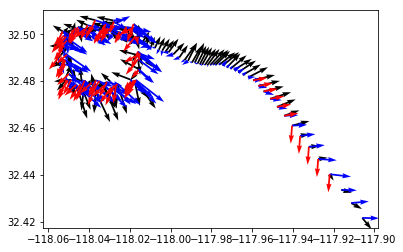

In [314]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T01','2018-04-20T22'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T01','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420_1kmboth_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')


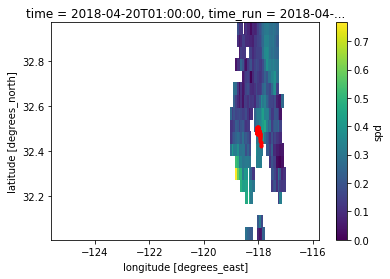

In [315]:
subset.spd[0,:,:].plot()
plt.plot(usv1.lon,usv1.lat,'r.')

In [309]:
hf1

<xarray.Dataset>
Dimensions:       (nProcParam: 7, nSites: 59, time: 132)
Coordinates:
    lat           (time) float64 32.5 32.5 32.5 32.49 ... 32.43 32.43 32.42
    lon           (time) float64 -118.0 -118.0 -118.0 ... -117.9 -117.9 -117.9
  * time          (time) datetime64[ns] 2018-04-20T01:00:00 ... 2018-04-20T22:50:00
    trajectory    float32 1002.0
    cell_depth    float32 4.2
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 37.08943 38.317318 ... 39.438015 38.567184
    site_lon      (nSites) float32 -122.27415 -123.072464 ... -123.33155
    site_code     (nSites) |S64 b'BIGC                     ' ... b'GCVE                     '
    site_netCode  (nSites) |S64 b'NPS                      ' ... b'BML                      '
    procParams    (nProcParam) float32 10.0 100.0 2.0 3.0 0.0 0.0 10.0
    u             (time) float32 -0.12 -0.12 -0.099999994 ... nan nan nan
    v             (time) float32 -0.26999998 -0.26999998 -0.

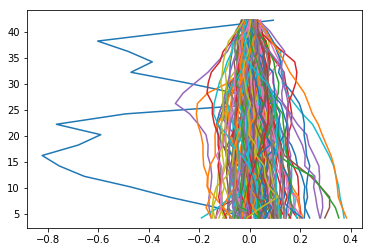

In [415]:
ds_usv2['spd']=np.sqrt(ds_usv2.vel_east**2+ds_usv2.vel_north**2)
for i in range(1,8000,50):
    plt.plot(ds_usv2.spd[i,0:20]-ds_usv2.spd[i,20],ds_usv2.cell_depth[0:20])



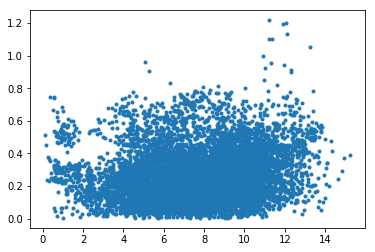

In [406]:
plt.plot(np.sqrt(ds_usv2.UWND_MEAN**2+ds_usv2.VWND_MEAN**2),ds_usv2.spd[:,0],'.')

In [ ]:
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T13','2018-04-20T15'))
#usv2 = usv1.where(usv1.ROLL>10)
usv1['droll']=usv1.ROLL.diff(dim='time')
usv2 = usv1.where(np.abs(usv1.droll>1))
#hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T00','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
ax1.quiver(usv1.lon,usv1.lat,usv1.vel_east,usv1.vel_north)
ax1.quiver(usv2.lon,usv2.lat,usv2.vel_east,usv2.vel_north,color='r')
#ax1.quiver(usv1.lon.where(usv1.ROLL>15),usv1.lat.where(usv1.ROLL>15),usv1.vel_east.where(usv1.ROLL>15),usv1.vel_north.where(usv1.ROLL>15),'r')
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420both_bias.png'
plt.savefig(fig_fname, transparent=False, format='png')
#usv2#the direction is turning as it moves around grid, in 12 hours it rotates almost 180 degrees
usv1 = ds_usv_subset.sel(time=slice('2018-04-20T05','2018-04-20T15'))
hf1 = ds_collocated_nearest.sel(time=slice('2018-04-20T00','2018-04-20T22'))
#print(usv1.lat)
ax1=plt.subplot(1,1,1)
#usv1.roll
#usv1['droll']=usv1.ROLL[:-1]-usv1.ROLL[1:]
#usv1['droll']=usv1.ROLL.diff(dim='time')
#ax1.plot(usv1.ROLL.diff(dim='time'),'r')
#ax1.plot(usv1.ROLL,'b')
usv1['dir2']=usv1.dir.copy(deep=True)
usv1['dir2'] = np.mod(usv1['dir2'],360)
ax1.plot(usv1.time.dt.hour,usv1.dir2,'g.')
#ax1.plot(usv1.ROLL.where(usv1.ROLL>15),'r')
#ax1.quiver(usv1.lon,usv1.lat,usv1.UWND_MEAN,usv1.VWND_MEAN,color='b')
#ax1.quiver(hf1.lon,hf1.lat,hf1.u,hf1.v,color='r')
#fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/hf_radar_tseries_420both_bias.png'
#plt.savefig(fig_fname, transparent=False, format='png')

